# N-grams Analysis Notebook

This notebook contains N-gram analysis that is within our datastory. If you installed the ```environment.yml``` then you will not need to download any additional packages. However if you did not you will need to download the following:

- ```pip install nltk```
- ```pip install worldcloud```
- ```pip install tqdm```
- ```pip install gc```
- ```pip install psutil```
- ```pip install textblob```
- ```pip install plotly```

#### Prerequisites

You will need to go to the ```src/data-explore``` notebook to generate our metadata and filter them by year. After doing so make sure you have a folder titled ```yearly``` within the ```datasets``` parent directory.

- ```datasets/yearly```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys 
import matplotlib.ticker as ticker
import os
import glob
import plotly.graph_objects as go # install plotly if you dont have it

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from wordcloud import WordCloud, STOPWORDS

import tqdm
import gc
import psutil
import re

from textblob import TextBlob

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('brown')

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package brown to /Users/simonlee/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Word Cloud Analysis (Unigram, Bigram, Trigram)

need to pip install ``textblob``

In [2]:
def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string

def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string 

def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

def plot_cloud(wordcloud, filename, a = False, b = False, c = False):
    date = filename[0:4]
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    if a:
        plt.title(date + " Most Relevant and Frequent Word Unigrams",fontdict={'fontsize': 24})
    if b:
        plt.title(date + " Most Relevant and Frequent Word Bigrams", fontdict={'fontsize': 24})
    if c:
        plt.title(date + " Most Relevant and Frequent Word Trigrams",fontdict={'fontsize': 24})
    plt.savefig('../figures/' + filename + '.png')
    plt.show()
    plt.close() 


def year_analysis(file):
    date = file[0:4]
    df = pd.read_csv(file, usecols=['video_info'])
    df_news = pd.read_csv('/Users/simonlee/ada-2022-project-chromegoldfish/datasets/news_channels.csv.gz')
    df_news['mainstream news organizations'] = df_news['mainstream news organizations'].str.lower()
    news_list = df_news['mainstream news organizations'].values.tolist()
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss)  # in bytes 
    print("Read in {} file".format(file))

    df["video_info"] = df["video_info"].apply(remove_urls)
    df["video_info"] = df["video_info"].apply(remove_symbols)
    df["video_info"] = df["video_info"].apply(unify_whitespaces)
    df["video_info"] = df["video_info"].str.lower()

    text = " ".join(i for i in df.video_info)
    print("text cleaned")

    list_common = ['follow','twitter','facebook','times', 'news', 'journal', 'youtube', 'subscribe', 'channel', 'us', 'cbs', 'knoxnews', 'video', 'new', 'cbsnews', 'com', 'visit',
    's', 'one', 'people', 'abc', 'cbs', 'year', 'week', 'day', 'years', 'daily', 'tonight', 'today', 'weeks', 'days', 'said', 'bloomberg', 'snapchat', 'instagram', 'media', 'press'
    'government', 'tv', 'home', 'york', 'city', 'u_s', 'follow_us', 'new_york', 'cbs_news', 'cbsnews_com', 'first_look', 'repair_com', 'angry_news', 'evening_news', 'knoxnews_com',
    'i_m', 'news_katie', 'he_s', 'bloomberg_news', 'york_times', 'voa_s', 'click_here', 'video_audio', 'view_article', 'times_video', 'that_s', 'part_1', 'part_2', 'please_visit',
    'us_twitter', 'abc_australia', 'york_city', 'obama_s', 'in_depth', 'hollywood_tv', 'youtube_com', 'video_report', 'visit_www', 'produced_abc', 'video_at', 'e_mail', 'period_com',
    'they_re', 'bloomberg_interview', 'year_old', 'years_old', 'like_us', 'dunya_tv', 'samaa_tv', 'rt_twitter', 'monday_friday', 'today_s', 'what_s', 's_important', 'upload_answer',
    'kmbc_s', 'cbs_evening', 'facebook_follow', 'us_facebook', 'visit_wsj', 'wsj_com', 'video_subscribe', 'facebook_join', 'wsj', 'produced', 'channel', 'see', 'talks', 'radio', 'p', 'u',
    'covering', 'coverage' ]

    # Creating a custom list of stopwords
    customStopwords=list(STOPWORDS) + list_common + news_list

    df["video_info"] = df["video_info"].apply(lambda x: ' '.join([word for word in x.split() if word not in (customStopwords)]))

    # bigram and trigram analysis 
    df["unigram_text"] = df["video_info"].apply(get_ngrams, n=1)
    df["bigram_text"] = df["video_info"].apply(get_ngrams, n=2)
    df["trigram_text"] = df["video_info"].apply(get_ngrams, n=3)

    unigram_list = df['unigram_text'].tolist()
    unigram_string = ' '.join(unigram_list)
    wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, collocations=False, normalize_plurals=False, stopwords=customStopwords).generate(unigram_string)
    print("Unigrams:")
    plot_cloud(wordcloud, date+'_unigram', a= True) 

    # bigram
    bigram_list = df['bigram_text'].tolist()
    bigram_string = ' '.join(bigram_list)
    wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, collocations=False, normalize_plurals=False, stopwords=customStopwords).generate(bigram_string)
    print("Bigrams:")
    plot_cloud(wordcloud, date+'_bigram', b= True) 

    # trigram
    trigram_list = df['trigram_text'].tolist()
    trigram_string = ' '.join(trigram_list)
    wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, collocations=False, normalize_plurals=False, stopwords=customStopwords).generate(trigram_string)
    print("Trigrams:")
    plot_cloud(wordcloud, date+'_trigram', c = True) 

    del df
    gc.collect()
    df=pd.DataFrame()
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss)  # in bytes


In [3]:
os.chdir("../datasets/yearly/")
filename = glob.glob('*.csv.gz')
filename = sorted(filename)
filename

['2005_videos.csv.gz',
 '2006_videos.csv.gz',
 '2007_videos.csv.gz',
 '2008_videos.csv.gz',
 '2009_videos.csv.gz',
 '2010_videos.csv.gz',
 '2011_videos.csv.gz',
 '2012_videos.csv.gz',
 '2013_videos.csv.gz',
 '2014_videos.csv.gz',
 '2015_videos.csv.gz',
 '2016_videos.csv.gz',
 '2017_videos.csv.gz',
 '2018_videos.csv.gz',
 '2019_videos.csv.gz']

76615680
Read in 2005_videos.csv.gz file
text cleaned
Unigrams:


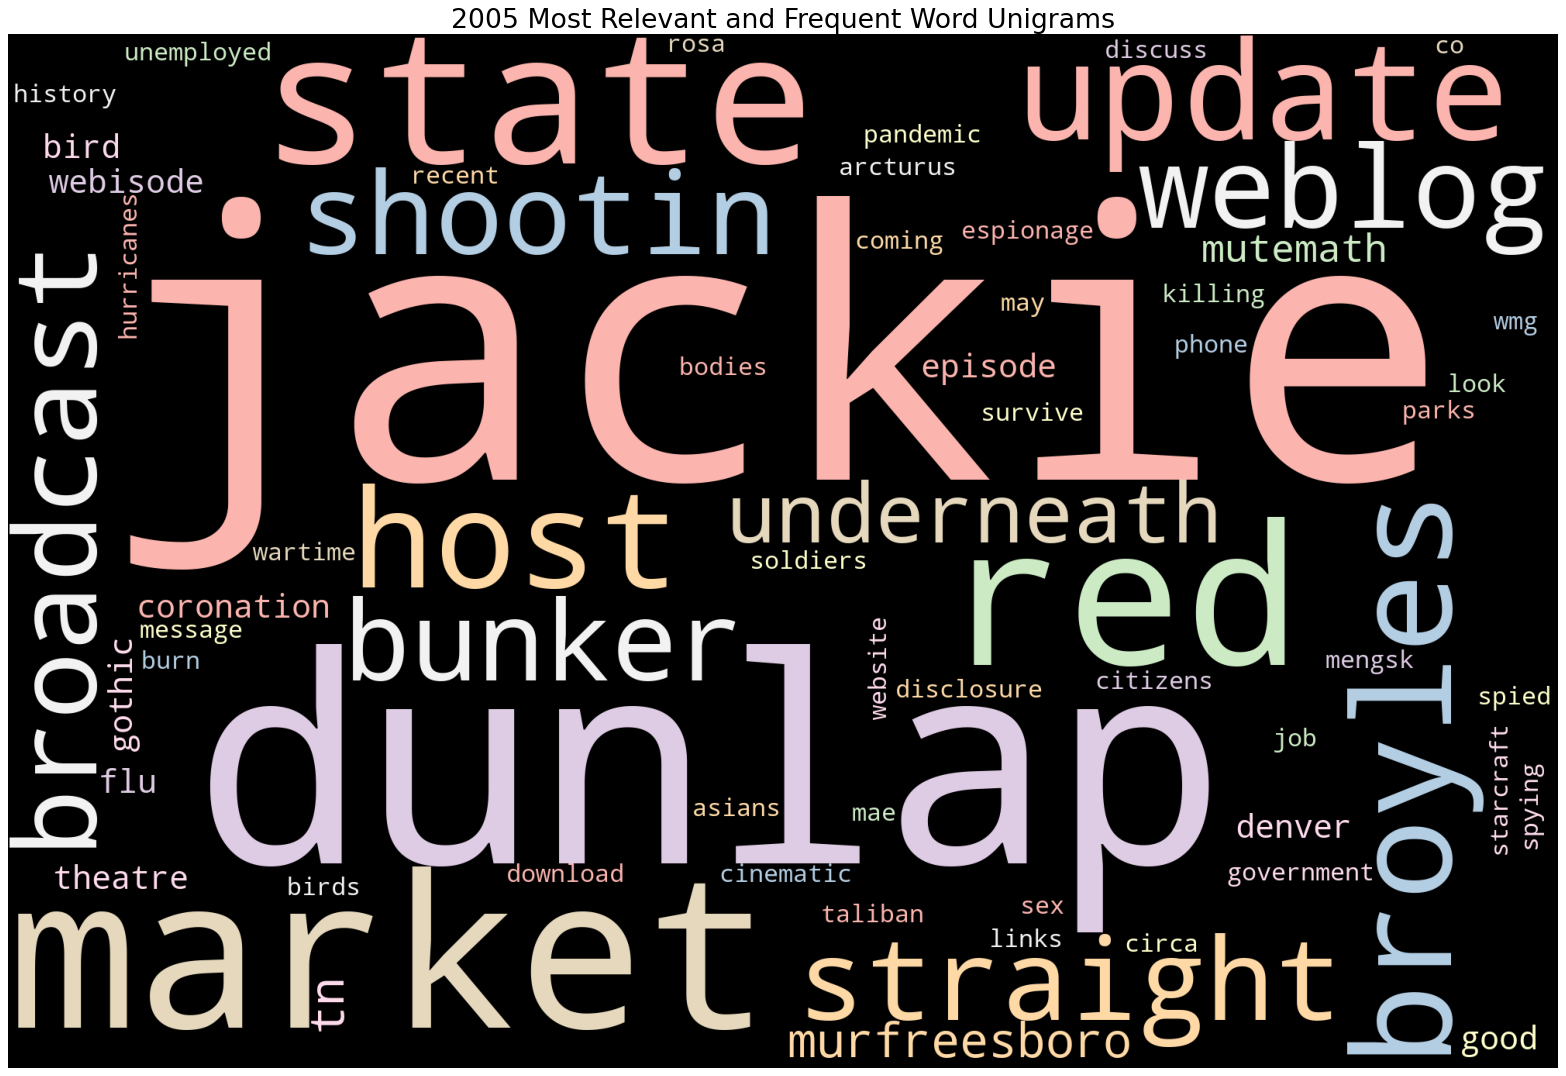

Bigrams:


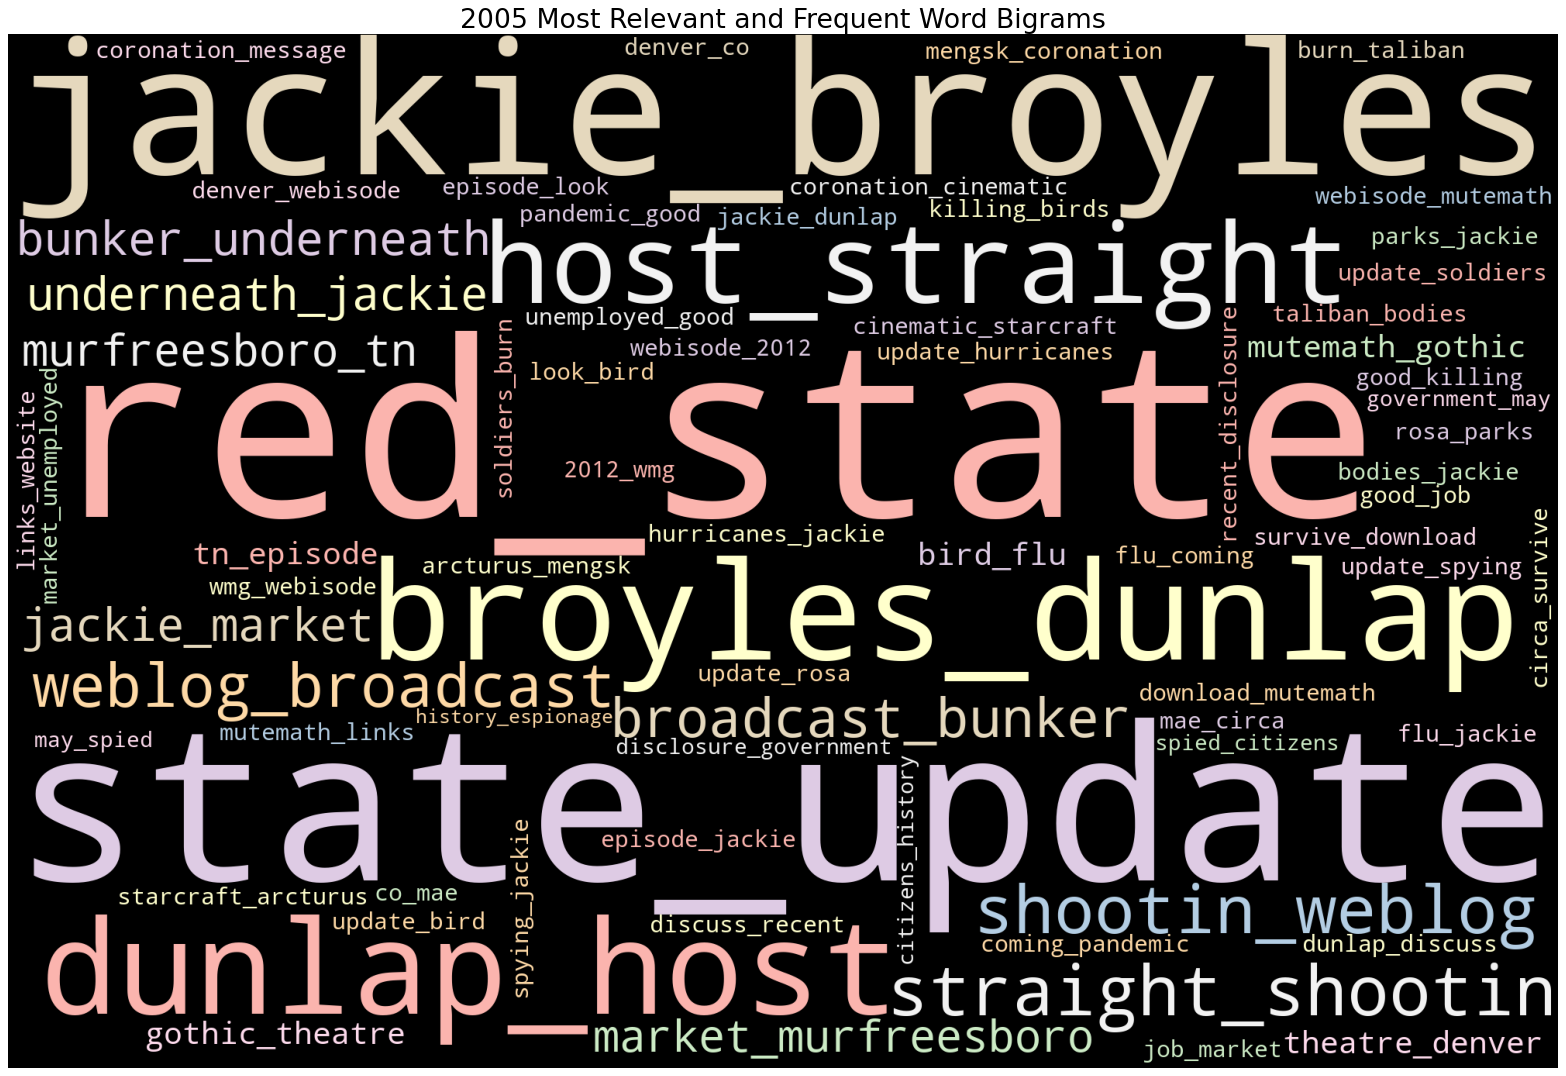

Trigrams:


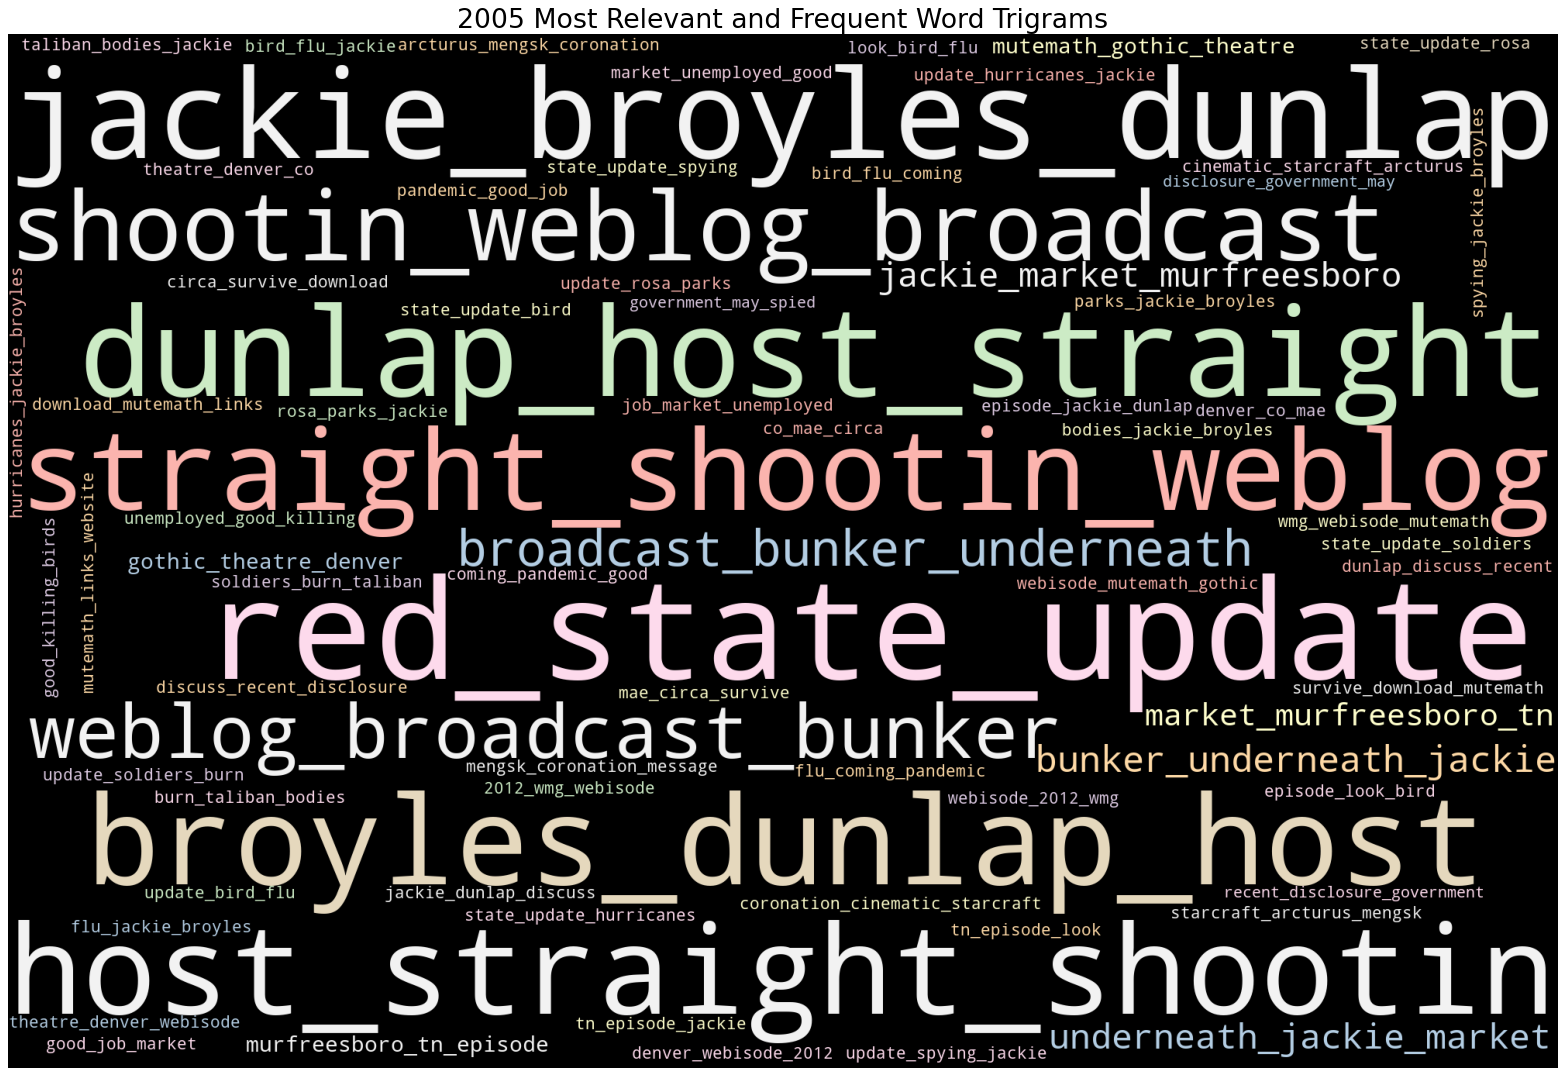

523390976


In [4]:
for file in filename:
    year_analysis(file)